In [121]:
import pandas as pd
import numpy as np
import seaborn as sb
import math
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve
from xgboost import XGBClassifier

## Load Data  

Perform the following data cleaning:  
* Drop columns "Name", "City", "Zip", "Bank", "BankState", "ApprovalDate", "DisbursementDate"

In [135]:
df = pd.read_csv('Xtrain.csv')
df_y = pd.read_csv('Ytrain.csv')
df = pd.concat([df, df_y['ChargeOff']], axis=1, sort=False)
df = df.drop(['Name', 'City', 'Zip', 'BankState', 'Bank', 'State', 'ApprovalDate', 'DisbursementDate'], axis= 1) 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 50000 non-null  int64  
 1   NAICS              50000 non-null  int64  
 2   ApprovalFY         50000 non-null  object 
 3   Term               50000 non-null  int64  
 4   NoEmp              50000 non-null  int64  
 5   NewExist           49993 non-null  float64
 6   CreateJob          50000 non-null  int64  
 7   RetainedJob        50000 non-null  int64  
 8   FranchiseCode      50000 non-null  int64  
 9   UrbanRural         50000 non-null  int64  
 10  RevLineCr          49847 non-null  object 
 11  LowDoc             49828 non-null  object 
 12  DisbursementGross  50000 non-null  object 
 13  BalanceGross       50000 non-null  object 
 14  GrAppv             50000 non-null  object 
 15  SBA_Appv           50000 non-null  object 
 16  ChargeOff          500

## Feature Transformation  

In [136]:
# ApprovalFY
# 1. Remove the non-numeric value 1976A
# 2. Convert the dtype to int

print(df['ApprovalFY'].unique(), "\n")
df['ApprovalFY'] = df['ApprovalFY'].replace('1976A', 1976)
df['ApprovalFY'] = df['ApprovalFY'].astype(int)
print(df['ApprovalFY'].unique())

['2010' '2002' '1994' '2006' '2008' '2000' '2007' '2005' '2001' '2011'
 '1996' '1984' '2004' '1989' '1999' '1998' '2003' '2009' '1997' '1992'
 '1990' '1993' '1985' '1983' '1991' '1995' '2012' '1986' '1987' '1982'
 '1988' '2013' '1981' '1978' '1979' '1980' '1977' '1973' '2014' '1976'
 '1974' '1975' '1971' '1972' '1970' '1969' '1976A'] 

[2010 2002 1994 2006 2008 2000 2007 2005 2001 2011 1996 1984 2004 1989
 1999 1998 2003 2009 1997 1992 1990 1993 1985 1983 1991 1995 2012 1986
 1987 1982 1988 2013 1981 1978 1979 1980 1977 1973 2014 1976 1974 1975
 1971 1972 1970 1969]


In [137]:
# DisbursementGross, BalanceGross, GrAppv, SBA_Appv
# 1. Convert the numeric format

money_cols = ['DisbursementGross', 'BalanceGross','GrAppv', 'SBA_Appv']
print(df[money_cols].head(), "\n")
df[money_cols] = df[money_cols].replace('[\$,]', '', regex=True).astype(float) 
print(df[money_cols].head())

  DisbursementGross BalanceGross          GrAppv        SBA_Appv
0    $2,000,000.00        $0.00   $2,000,000.00   $1,500,000.00 
1       $17,000.00        $0.00      $17,000.00      $17,000.00 
2       $17,000.00        $0.00      $17,000.00       $8,500.00 
3      $137,000.00        $0.00     $137,000.00     $123,300.00 
4       $46,665.00        $0.00      $25,000.00      $12,500.00  

   DisbursementGross  BalanceGross     GrAppv   SBA_Appv
0          2000000.0           0.0  2000000.0  1500000.0
1            17000.0           0.0    17000.0    17000.0
2            17000.0           0.0    17000.0     8500.0
3           137000.0           0.0   137000.0   123300.0
4            46665.0           0.0    25000.0    12500.0


In [138]:
# LowDoc
# 1. Remove invalid values
# 2. Convert the format from text (N/Y) to boolean

print(df['LowDoc'].unique(), "\n")
df['LowDoc'] = df['LowDoc'].replace({'S': None, '0': None, 'C':None, 'A':None, 'R':None})
df['LowDoc'] = df['LowDoc'].replace({'N': 0, 'Y':1})
print(df['LowDoc'].unique())

['N' 'Y' nan 'S' '0' 'C' 'A' 'R'] 

[ 0.  1. nan]


In [139]:
# RevLineCr
# 1. Remove invalid values
# 2. Convert the format from text (N/Y) to boolean

print(df['RevLineCr'].unique(), "\n")
df['RevLineCr'] = df['RevLineCr'].replace({'T': None, 'N': 0, 'Y':1, '0': 0})
print(df['RevLineCr'].unique())

['N' 'Y' 'T' '0' nan] 

[ 0.  1. nan]


In [140]:
# NewExist
# 1. Remove invalid values
# 2. Convert the format from text (N/Y) to boolean

print(df['NewExist'].unique(), "\n")
df['NewExist'] = df['NewExist'].replace(0, None)
print(df['NewExist'].unique())

[ 1.  2.  0. nan] 

[ 1.  2. nan]


In [141]:
# FranchiseCode, CreateJob, RetainedJob
# 1. Convert from continuous data to categorical data

print(df['FranchiseCode'].unique(), "\n")
df['FranchiseCode'] = df['FranchiseCode'].replace(1,0 )
df['FranchiseCode'] = np.where((df.FranchiseCode != 0 ), 1, 0)
print(df['FranchiseCode'].unique(), "\n")
df.rename(columns={"FranchiseCode": "Franchised"}, inplace=True)

print(df['CreateJob'].unique(), "\n")
df['CreateJob'] = np.where((df.CreateJob > 0 ),1,df.CreateJob)
print(df['CreateJob'].unique(), "\n")

print(df['RetainedJob'].unique(), "\n")
df['RetainedJob'] = np.where((df.RetainedJob > 0 ),1,df.RetainedJob)
print(df['RetainedJob'].unique())

[    0     1  9050 25035 66347 17900 36995 64609 77020 89352 22470 15100
 68020 78760 34650 10611 68150 67750   900 52000 32055 30811 87580  8023
 10494 67255 52875 64976 54100 17998 66910 89775 71685  6140 10676 79140
 70879 89785 68060 39700 79153 69146  1350 64950 67759 75000 74782 89639
 79950 50850 66694 10703 21425 29237 50564  1507 82285 16868 32130 10625
 21780 79220 20550  2105 68250 61400 37469 48020 65140 38510 17750 77174
  8659 44725 65925 19755 33150 71650 74770 34845 47400 77895 81965 84725
 89769 79902 62360  1560 58686 20546 35706 21420 66666 10484 66486 50954
 81630 65100 52070 71720 64211 65152 46750 65250 38605 25650 32418 53650
 17205 81612 38601 10605   407 43570 79350 65150 31154 75900 31360 48450
 14839 66615  7969 46425 28883 81621 47426 56575 21870 64900 64657 23000
 61901 17584 73525 70671 75410 66643 39598 24850 28960 55825 70554 29582
 10528 45150 33165 41850 39588 80025 26650 57601 58616 60590 51778 24706
 81606 66350 73675 11950 46410 49952 59225 69058 10

In [142]:
df.isnull().sum()

Id                      0
NAICS                   0
ApprovalFY              0
Term                    0
NoEmp                   0
NewExist                7
CreateJob               0
RetainedJob             0
Franchised              0
UrbanRural              0
RevLineCr            1527
LowDoc                352
DisbursementGross       0
BalanceGross            0
GrAppv                  0
SBA_Appv                0
ChargeOff               0
dtype: int64

In [129]:
df = df.dropna()
df['LowDoc'] = df['LowDoc'].astype(int)
df['NewExist'] = df['NewExist'].astype(int)
df['RevLineCr'] = df['RevLineCr'].astype(int)

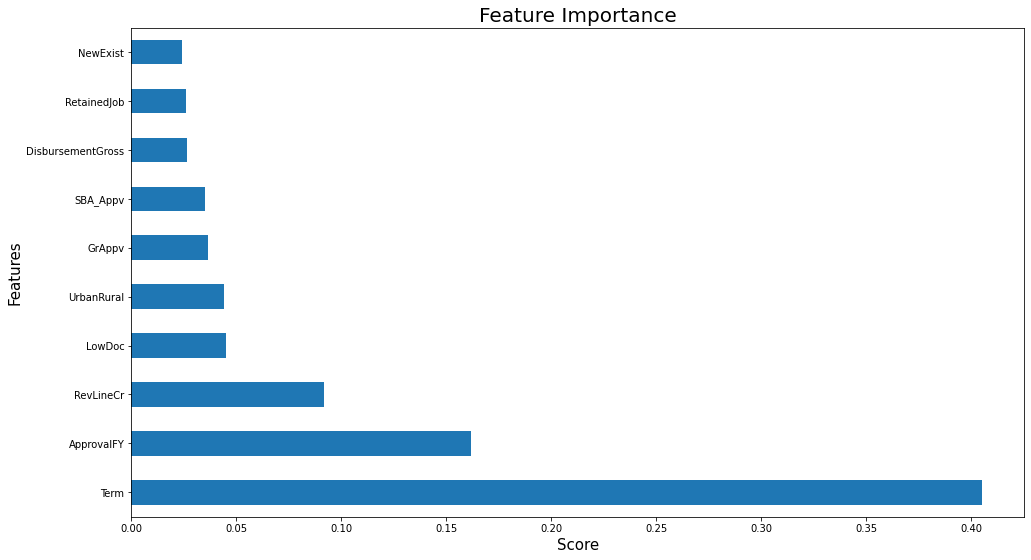

In [130]:
y = df["ChargeOff"]
x = df.drop(['ChargeOff'], axis= 1)

model = XGBClassifier()
model.fit(x,y)

feat_importances = pd.Series(model.feature_importances_, index = x.columns)

f, ax = plt.subplots(figsize = (16,9))

feat_importances.nlargest(10).plot(kind = 'barh')

plt.title('Feature Importance', fontsize = 20)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Score', fontsize = 15)

plt.show()

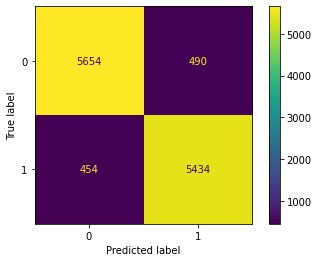

Classification Report: 
               precision    recall  f1-score   support

           0      0.926     0.920     0.923      6144
           1      0.917     0.923     0.920      5888

    accuracy                          0.922     12032
   macro avg      0.921     0.922     0.922     12032
weighted avg      0.922     0.922     0.922     12032



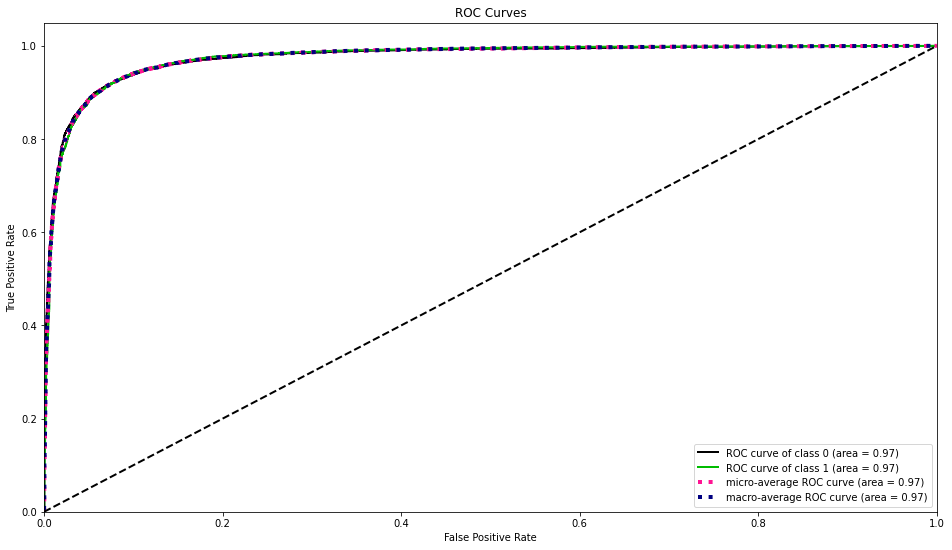

In [131]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['ChargeOff'], axis= 1), df["ChargeOff"], test_size = 0.25, random_state=0)
def model_evaluation(algo,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_train_ypred = algo.predict(X_train)
    y_train_prob = algo.predict_proba(X_train)[:,-1]

    y_test_ypred = algo.predict(X_test)
    y_test_prob = algo.predict_proba(X_test)[:,-1]
    y_probas = algo.predict_proba(X_test)
    
    # Confussion Matrix
    
    plot_confusion_matrix(algo, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    # ROC Curve
    
    skplt.metrics.plot_roc(y_test, y_probas,figsize=(16,9))

xgb = XGBClassifier()
model_evaluation(xgb, x_train, y_train, x_test, y_test)

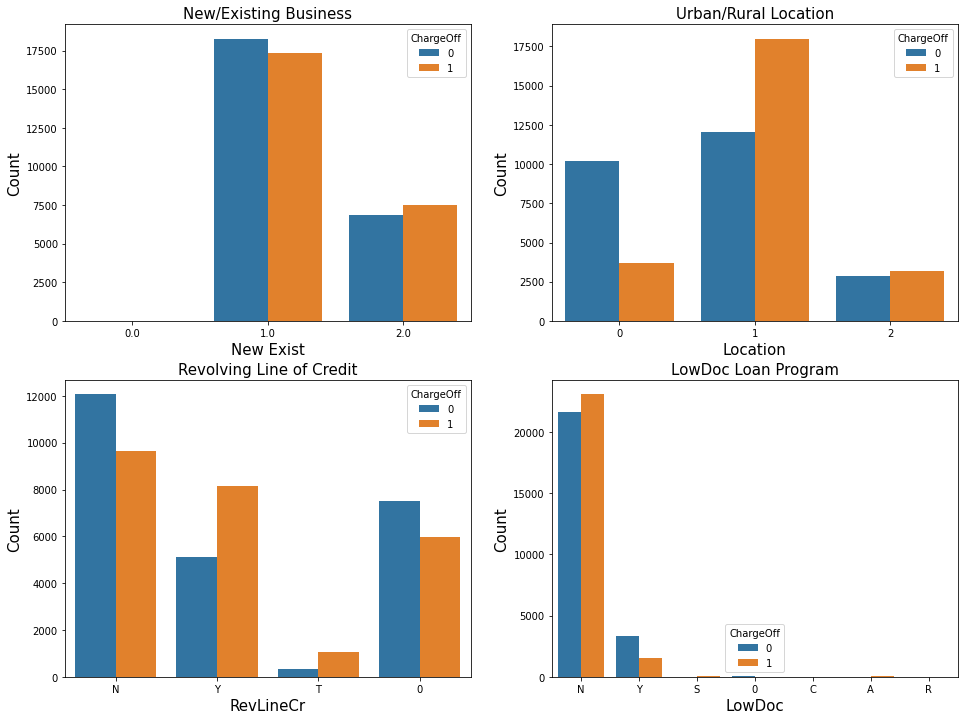

In [60]:
# NewExist column
_, axes = plt.subplots(2, 2, figsize=(16,12))

sb.countplot(x = "NewExist", hue = "ChargeOff", data = df, ax=axes[0, 0])
axes[0, 0].set_title('New/Existing Business', fontsize=15)
axes[0, 0].set_xlabel('New Exist', fontsize=15)
axes[0, 0].set_ylabel('Count', fontsize=15)

sb.countplot(x = "UrbanRural", hue = "ChargeOff", data = df, ax=axes[0, 1])
axes[0, 1].set_title('Urban/Rural Location', fontsize=15)
axes[0, 1].set_xlabel('Location', fontsize=15)
axes[0, 1].set_ylabel('Count', fontsize=15)

sb.countplot(x = "RevLineCr", hue = "ChargeOff", data = df, ax=axes[1, 0])
axes[1, 0].set_title('Revolving Line of Credit', fontsize=15)
axes[1, 0].set_xlabel('RevLineCr', fontsize=15)
axes[1, 0].set_ylabel('Count', fontsize=15)

sb.countplot(x = "LowDoc", hue = "ChargeOff", data = df, ax=axes[1, 1])
axes[1, 1].set_title('LowDoc Loan Program', fontsize=15)
axes[1, 1].set_xlabel('LowDoc', fontsize=15)
axes[1, 1].set_ylabel('Count', fontsize=15)

plt.show()

In [134]:
df = pd.read_csv('Xtest.csv', dtype={"ApprovalFY": object})
print(df['RevLineCr'].unique(), "\n")
df['RevLineCr'] = np.where((df['RevLineCr'] == "N") | (df['RevLineCr'] == "Y"), df['RevLineCr'], np.nan)
df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y': 1})
print(df['RevLineCr'].unique(), "\n")

['Y' '0' 'N' 'T' nan '1' 'Q' 'R' '2'] 

[ 1. nan  0.] 

